# Library

In [1]:
from astropy.table import Table
from astropy.io import ascii

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

In [3]:
import numpy as np
import seaborn as sns

def makeSpecColors(n, palette='Spectral'):
	#	Color palette
	palette = sns.color_palette(palette, as_cmap=True,)
	palette.reversed

	clist_ = [palette(i) for i in range(palette.N)]
	cstep = int(len(clist_)/n)
	clist = [clist_[i*cstep] for i in range(n)]
	return clist
def calc_apparent_mag(d, dprime, m):
    """
    Calculate the apparent magnitude at a distance dprime, given the apparent magnitude m at distance d.

    Parameters:
    -----------
    d : float
        Distance to the object in parsecs
    dprime : float
        Distance to the object in parsecs for which the magnitude is to be calculated
    m : float
        Apparent magnitude of the object at distance d

    Returns:
    --------
    mprime : float
        Apparent magnitude of the object at distance dprime
    """
    mprime = m + 5 * np.log10(dprime / d)
    return mprime


def scale_depth(depth, t0, t1):
    tratio = t1/t0
    return depth+2.5*np.log10(np.sqrt(tratio))

def scale_exptime(m0, m1):
    delm = m1 - m0
    tratio = 10**(delm/(1.25))
    return tratio

# Input

In [4]:
from astropy.time import Time
t_gw = Time('2019-04-25T00:00:00', format='isot', scale='utc')
t_now = Time('2019-04-26T06:00:00', format='isot', scale='utc')

In [5]:
phase = (t_now-t_gw).jd
print(phase, 'days')

1.25 days


## Table

# Result

## Light Curve

In [6]:
def expect_AT2017gfo(dprime, phase, filterlist=['g', 'r', 'i', 'z', 'y', 'J', 'H', 'K',], plot=True):
	# filterlist = ['g', 'r', 'i', 'z', 'y', 'J', 'H', 'K',]
	# for filte in ['g', 'r', 'i', 'z', 'y',]:
	colors = makeSpecColors(len(filterlist), palette='Spectral')
	expected_magdict = {}
	d = 40 # [Mpc]
	#	AT2017gfo Table
	intbl = ascii.read('../data/AT2017gfo_phot_modified.dat', header_start=0, data_start=1)
	for ff, filte in enumerate(filterlist):
		# plt.plot(intbl['Phase'], intbl[filte], 'o-', mfc='w', label=filte)
		mprime = calc_apparent_mag(d, dprime, intbl[filte])
		mag_now = np.interp(phase, intbl['Phase'][~intbl[filte].mask], mprime[~intbl[filte].mask])
		# if mag_now > 10:
		# 	label = f"{filte}={mag_now:.1f}"
		# else:
		# 	label = filte
		label = f"{filte}={mag_now:.1f}"
		expected_magdict[filte] = mag_now
		if plot:
			# plt.plot(intbl['Phase'], mprime, 'o-', mfc='w', label=label)
			# plt.plot(intbl['Phase'][~mprime.mask], mprime[~mprime.mask], 'o-', mfc='w', label=label)
			plt.plot(intbl['Phase'][~mprime.mask], mprime[~mprime.mask], 'o-', c=colors[-ff-1], mfc='w', label=label)

	if plot:
		plt.axvspan(xmin=1e-3, xmax=phase, color='grey', alpha=0.25)
		plt.axvline(x=phase, ls='-', color='tomato', lw=3, alpha=1.0, zorder=1, label=f'Now {phase:.1f}d')
		plt.xlabel('Phase')
		plt.ylabel('Mag [AB]')
		plt.title(f"AT2017gfo-like KN (d={dprime:.1f} Mpc)")
		plt.xlim([0, phase+2])
		# yl, yu = plt.ylim()
		yl = np.min(list(expected_magdict.values()))-0.25
		yu = np.max(list(expected_magdict.values()))+3
		plt.ylim([yu, yl])
		plt.legend(framealpha=0.0, fontsize=10, loc='lower left', ncol=3)
		plt.grid('both', ls='--', c='silver', alpha=0.5)
		plt.tight_layout()
	return expected_magdict

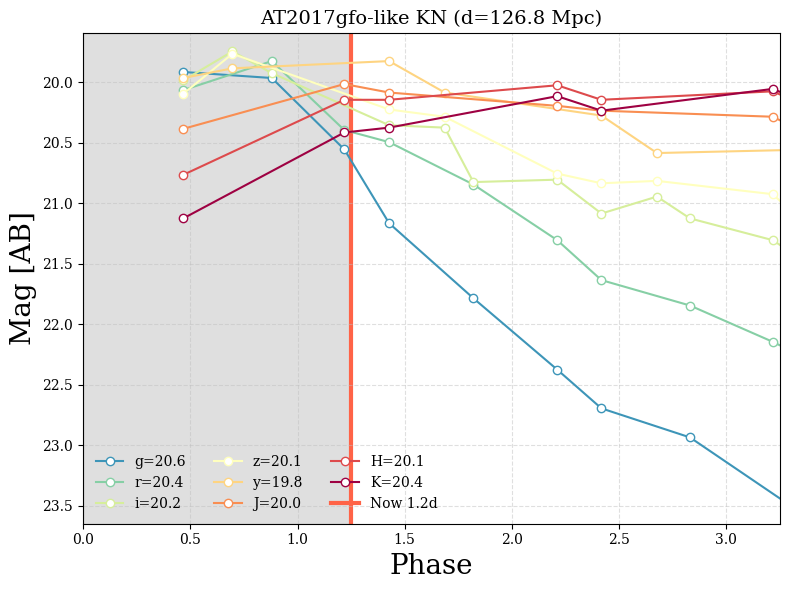

In [7]:
fig = plt.figure(figsize=(8, 6))
dprime = 126.8
filterlist = ['g', 'r', 'i', 'z', 'y', 'J', 'H', 'K',]
expected_magdict = expect_AT2017gfo(dprime, phase, filterlist=filterlist, plot=True)

## Comparison with the depth

In [8]:
gcktbl = ascii.read("../data/gecko.facilities.tsv")
gcktbl

obs,pixelscale,x,y,fov,fovx,fovy,foveff,hemisphere,exptime,depth,filter
str9,float64,int64,int64,float64,float64,float64,float64,str1,int64,float64,str5
LOAO,0.794,2048,2048,0.204,27.102,27.102,38.328,N,10,20.7,R
CBNUO,1.04,4096,4096,1.4,70.997,70.997,100.405,N,10,18.6,R
SAO,0.13,9576,6388,0.794,20.7,13.8,24.878,N,10,19.7,R
KCT,0.724,4096,4096,0.679,49.425,49.425,69.898,S,10,20.0,r
MAO,0.266,4096,4096,0.092,18.159,18.159,25.681,N,2,22.0,R
DOAO,0.462,2048,2048,0.069,15.7696,15.7696,22.302,N,3,19.0,R
SOAO,0.4454,2048,2048,0.064,15.203,15.203,21.5,N,15,19.4,R
KHAO,0.3525,2048,2048,0.04,12.032,12.032,17.016,N,15,18.4,R
MDFTS,0.757,1663,1252,0.092,20.982,15.796,26.263,N,10,18.4,R


In [9]:
gcktbl['depth_3min'] = scale_depth(gcktbl['depth'], gcktbl['exptime'], 3.)
gcktbl['depth_4min'] = scale_depth(gcktbl['depth'], gcktbl['exptime'], 4.)
gcktbl['depth_10min'] = scale_depth(gcktbl['depth'], gcktbl['exptime'], 10.)
gcktbl['depth_24min'] = scale_depth(gcktbl['depth'], gcktbl['exptime'], 24.)
gcktbl['depth_30min'] = scale_depth(gcktbl['depth'], gcktbl['exptime'], 30.)
gcktbl['depth_60min'] = scale_depth(gcktbl['depth'], gcktbl['exptime'], 60.)

/var/folders/73/438czwkx0jb_7z61gc79vcb40000gn/T/ipykernel_84895/2392184219.py:37: RuntimeWarning: divide by zero encountered in log10
  return depth+2.5*np.log10(np.sqrt(tratio))


In [10]:
indx_smnet = np.where(
    (gcktbl['obs']=='LOAO') |
    (gcktbl['obs']=='CBNUO') |
    (gcktbl['obs']=='SAO') |
    (gcktbl['obs']=='KCT') |
    (gcktbl['obs']=='RASA36') |
    (gcktbl['obs']=='DOAO') |
    (gcktbl['obs']=='KHAO') |
    (gcktbl['obs']=='MDFTS') |
    (gcktbl['obs']=='LSGT') |
    (gcktbl['obs']=='MAAO') |
    (gcktbl['obs']=='DNSM')
)

gcktbl[indx_smnet]

obs,pixelscale,x,y,fov,fovx,fovy,foveff,hemisphere,exptime,depth,filter,depth_3min,depth_4min,depth_10min,depth_24min,depth_30min,depth_60min
str9,float64,int64,int64,float64,float64,float64,float64,str1,int64,float64,str5,float64,float64,float64,float64,float64,float64
LOAO,0.794,2048,2048,0.204,27.102,27.102,38.328,N,10,20.7,R,20.046401568399578,20.202574989159952,20.7,21.175264052139507,21.296401568399578,21.672689062979554
CBNUO,1.04,4096,4096,1.4,70.997,70.997,100.405,N,10,18.6,R,17.94640156839958,18.102574989159955,18.6,19.07526405213951,19.19640156839958,19.572689062979556
SAO,0.13,9576,6388,0.794,20.7,13.8,24.878,N,10,19.7,R,19.046401568399578,19.202574989159952,19.7,20.175264052139507,20.296401568399578,20.672689062979554
KCT,0.724,4096,4096,0.679,49.425,49.425,69.898,S,10,20.0,r,19.34640156839958,19.502574989159953,20.0,20.475264052139508,20.59640156839958,20.972689062979555
DOAO,0.462,2048,2048,0.069,15.7696,15.7696,22.302,N,3,19.0,R,19.0,19.156173420760375,19.65359843160042,20.12886248373993,20.25,20.626287494579977
KHAO,0.3525,2048,2048,0.04,12.032,12.032,17.016,N,15,18.4,R,17.526287494579975,17.68246091534035,18.179885926180397,18.655149978319905,18.776287494579975,19.15257498915995
MDFTS,0.757,1663,1252,0.092,20.982,15.796,26.263,N,10,18.4,R,17.746401568399577,17.90257498915995,18.4,18.875264052139507,18.996401568399577,19.372689062979553
RASA36,2.36,4096,4096,7.21,161.109,161.109,227.843,S,10,19.2,r,18.546401568399578,18.702574989159952,19.2,19.675264052139507,19.796401568399578,20.172689062979554
LSGT,0.268,4656,3520,0.091,20.797,15.723,26.071,S,10,20.1,r,19.44640156839958,19.602574989159955,20.1,20.57526405213951,20.69640156839958,21.072689062979556


# Required Exposure Time

In [100]:
obs = "LOAO"
# obs = "SAO"
filte = 'r'
exptime0 = 10*60 # [min]
depth = gcktbl[f'depth_10min'][gcktbl['obs']==obs].item()
m = expected_magdict[filte]

In [101]:
import numpy as np

def exptime_for_mag(m, depth, exptime0):
    """
    Given the brightness of the target source m, the depth of the telescope, and the initial exposure time,
    returns the exposure time required to observe the target source.

    Parameters
    ----------
    m : float or numpy.ndarray
        The brightness of the target source in magnitudes.
    depth : float
        The depth of the telescope in magnitudes.
    exptime0 : float
        The initial exposure time in seconds.

    Returns
    -------
    float or numpy.ndarray
        The exposure time required to observe the target source in seconds.
    """
    exptime = exptime0 * 10**((m - depth) / 2.5)
    return exptime

In [102]:
total_exptime = exptime_for_mag(m, depth, exptime0)

print(f"The required exposure time for observing a source with magnitude {m} is {total_exptime:.2f} seconds.")


The required exposure time for observing a source with magnitude 20.410607315873445 is 459.61 seconds.


In [128]:
def find_exposure_time(exp_min, obs_min, total_time, tolerence=10):
    closest_time = float('inf')
    closest_tuple = None

    for n in range(obs_min, int(total_time // exp_min) + 1):
        for t in range(exp_min, 301, 30):
            exp_time = n * t
            diff = abs(exp_time - total_time)
            if diff < closest_time:
                closest_time = diff
                closest_tuple = (t, n)
    return closest_tuple


In [129]:
# Example usage:
exp_min = 60
obs_min = 3

exp_time, obs_count = find_exposure_time(exp_min, obs_min, int(total_exptime))
print(f"Exposure time: {exp_time}s x{obs_count}")
print(f"{total_exptime:.1f}s - {exp_time*obs_count:.1f}s = {total_exptime-exp_time*obs_count:.1f}s")

Exposure time: 150s x3
459.6s - 450.0s = 9.6s
